# Extract hornets from originals in boxes
From the bounding-box labelled data, we crop the images of the hornets and save them for training a classifier.

In [1]:
import os
import sys
import glob
import cv2
import warnings
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split


# Root directory
root_dir = '/Users/Holmes/Research/Projects/vespai'
sys.path.insert(0, root_dir)

# Data directory
data_dir = os.path.join(root_dir, 'datasets')
image_dir = os.path.join(data_dir, 'boxes-21')

# New data
new_dir = os.path.join(data_dir, 'extracts-21')
os.makedirs(new_dir, exist_ok=True)
os.makedirs(os.path.join(new_dir, 'train'), exist_ok=True)
os.makedirs(os.path.join(new_dir, 'val'), exist_ok=True)
os.makedirs(os.path.join(new_dir, 'test'), exist_ok=True)

# Automatically reload imported programmes
%reload_ext autoreload
%autoreload 2

## Load images and labels

In [2]:
# Gather list of image filenames
batch_names = ['train', 'test', 'val']
image_files = []

for batch in batch_names:
    image_files += glob.glob(os.path.join(image_dir, 'images', batch, '*.*'))

# Load images
images = []
for file in image_files:
    images.append(cv2.imread(file))  # In BGR format

# Load corresponding labels
labels = []
for file in image_files:
    
    # Generate label_path
    if '/images/' in file:
        
        # Swap substrings /images/ for /labels/ and ammend ext to .txt
        head, tail = file.split('/images/')
        root = os.path.splitext(head + '/labels/' + tail)[0]
        label_path = root + '.txt'
        
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        labels.append(np.loadtxt(label_path, dtype=np.float32))


## Crop boxed segments and save with corresponding class IDs

In [3]:
# Store extracted segments and corresponding class IDs
extracts = []
classes = []
class_dict = {
    0: 'Vespa crabro',
    1: 'Vespa velutina',
}

# Iterate over images
for image, boxes in zip(images, labels):
    
    im_height, im_width, _ = image.shape
    
    # One box in image
    if boxes.size == 5:
        boxes = np.expand_dims(boxes, axis=0)
        
    if not boxes.size == 0:     
        for [class_number, x_center, y_center, width, height] in boxes:
            
            # Crop box
            x0 = int(im_width * (x_center - width / 2))   # left-side x
            x1 = int(im_width * (x_center + width / 2))   # right-side x
            y0 = int(im_height * (y_center - height / 2))  # top-side y
            y1 = int(im_height * (y_center + height / 2))  # bottom-side x    
            extracts.append(image[y0:y1, x0:x1, :])
            classes.append(int(class_number))
            


### Split into train/val/test sets in ratio 80:10:10

In [4]:
# Split train/nontrain as 80:20
ex_dict = {}
cl_dict = {}
ex_dict['train'], ex_dict['nontrain'], cl_dict['train'], cl_dict['nontrain'] = \
train_test_split(
    extracts, classes, test_size=0.2, shuffle=True,
)

# Split non-training data test/val as 10:10
ex_dict['val'], ex_dict['test'], cl_dict['val'], cl_dict['test'] = train_test_split(
    ex_dict['nontrain'], cl_dict['nontrain'], test_size=0.5, shuffle=True
)

extract_num = 0  # Count extracts
subsets = ['train', 'val', 'test']
for subset in subsets:
    for image, class_num in zip(ex_dict[subset], cl_dict[subset]):
        
        # Save extract
        filename = 'extract_{:04d}_class_{}.jpeg'.format(extract_num, int(class_num))
        cv2.imwrite(os.path.join(new_dir, subset, filename), image)
        extract_num += 1
    

### Plot example of extraction

Class number:  1
Class name:  Vespa velutina


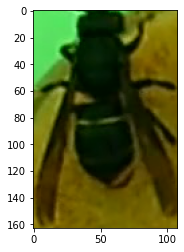

In [5]:
seg = np.random.randint(len(extracts), size=1)[0]
img = extracts[seg]
print('Class number: ', classes[seg])
print('Class name: ', class_dict[classes[seg]])

plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

### Example original image

Original image shape:  (1080, 1920, 3)
Raw box label data:  [0.    0.525 0.421 0.085 0.103]


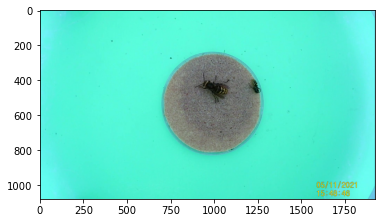

In [6]:
# A prototype original image
print('Original image shape: ', images[0].shape)
print('Raw box label data: ', labels[0])
plt.imshow(cv2.cvtColor(images[0], cv2.COLOR_BGR2RGB))
plt.show()